### Clustering Code ###

This section of code corresponds with section 2.3 of the project, and is primarily applied to an image of my hamster, Tofu. 

(No hamsters were harmed in the making of this project!)

In [9]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from skimage import segmentation
from skimage.segmentation import quickshift
from skimage.util import img_as_float
from skimage.transform import rescale
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import sobel, gaussian
from scipy import ndimage as ndi

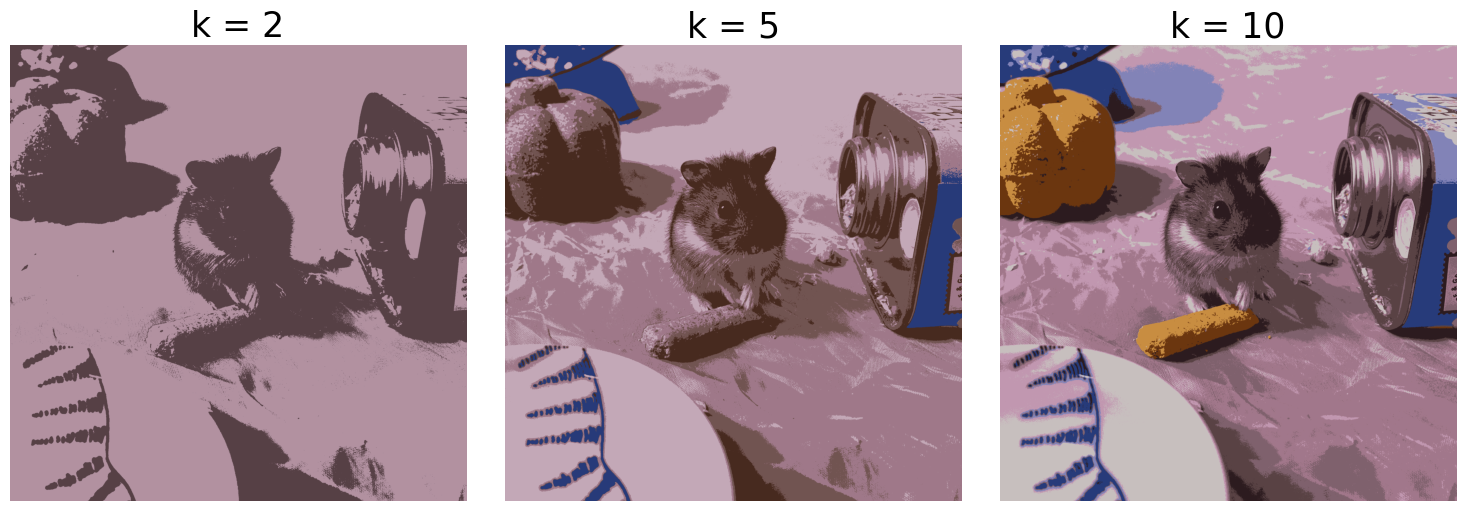

In [ ]:
# load and normalise the image
image = io.imread('IMG_8886.jpeg')
image = image / 255.0

# reshape image to 2D array of pixels
pixels = image.reshape(-1, 3)

# define k values for comparison
k_values = [2, 5, 10]
clustered_images = []

# apply K-Means clustering for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_
    clustered = colors[labels].reshape(image.shape)
    clustered_images.append(clustered)

# plot side-by-side comparisons
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(clustered_images[i])
    ax.set_title(f'k = {k_values[i]}', fontsize=25)
    ax.axis('off')

plt.tight_layout()
plt.show()


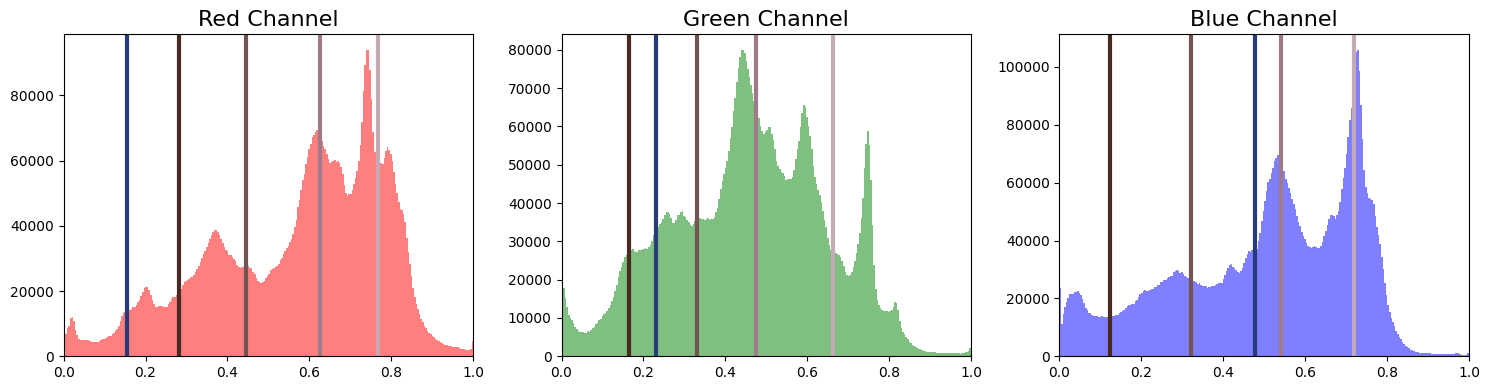

In [14]:
# apply K-Means for k=5
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(pixels)
colors = kmeans.cluster_centers_

# plot RGB histograms with cluster centers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
channel_names = ['Red', 'Green', 'Blue']
channel_colors = ['r', 'g', 'b']

for i, ax in enumerate(axes):
    channel_data = pixels[:, i]
    ax.hist(channel_data, bins=256, color=channel_colors[i], alpha=0.5)
    ax.set_title(f'{channel_names[i]} Channel', fontsize=16)
    ax.set_xlim(0, 1)
    
    # overlay cluster centers
    for c in colors:
        ax.axvline(c[i], color=c, linewidth=3)

plt.tight_layout()
plt.show()


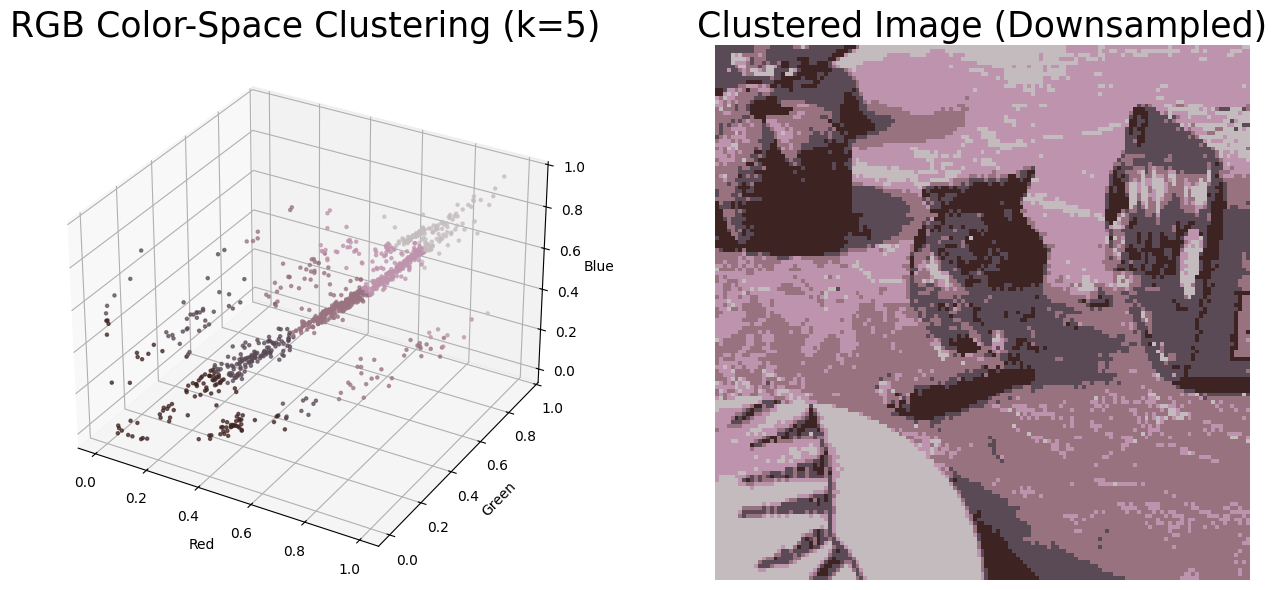

In [ ]:
# downsample pixels for faster clustering
n_samples = min(5000, len(pixels))
sample_idx = np.random.choice(len(pixels), n_samples, replace=False)
sample_pixels = pixels[sample_idx]

# fit MiniBatchKMeans
k = 5
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=256)
kmeans.fit(sample_pixels)

# downsize image to reduce computational and rendering cost
scale = 20 
small_image = image[::scale, ::scale, :]
flat_small = small_image.reshape(-1, 3)
small_labels = kmeans.predict(flat_small)
small_clustered = kmeans.cluster_centers_[small_labels].reshape(small_image.shape)

# sample pixels for RGB scatter plot
plot_samples = min(1000, len(pixels))
plot_idx = np.random.choice(len(pixels), plot_samples, replace=False)
plot_pixels = pixels[plot_idx]
plot_labels = kmeans.predict(plot_pixels)
plot_colors = kmeans.cluster_centers_[plot_labels]

# create side-by-side plot
fig = plt.figure(figsize=(14, 6))

# left: 3D RGB color-space clustering
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(plot_pixels[:, 0], plot_pixels[:, 1], plot_pixels[:, 2],
            c=plot_colors, s=5, alpha=0.7)
ax1.set_xlabel('Red')
ax1.set_ylabel('Green')
ax1.set_zlabel('Blue')
ax1.set_title(f'RGB Color-Space Clustering (k={k})', fontsize = 25)

# right: downsampled clustered image
ax2 = fig.add_subplot(122)
ax2.imshow(small_clustered)
ax2.set_title('Clustered Image (Downsampled)', fontsize = 25)
ax2.axis('off')

plt.tight_layout()
plt.show()

✅ Completed segmentation with kernel_size=3
✅ Completed segmentation with kernel_size=7
✅ Completed segmentation with kernel_size=15


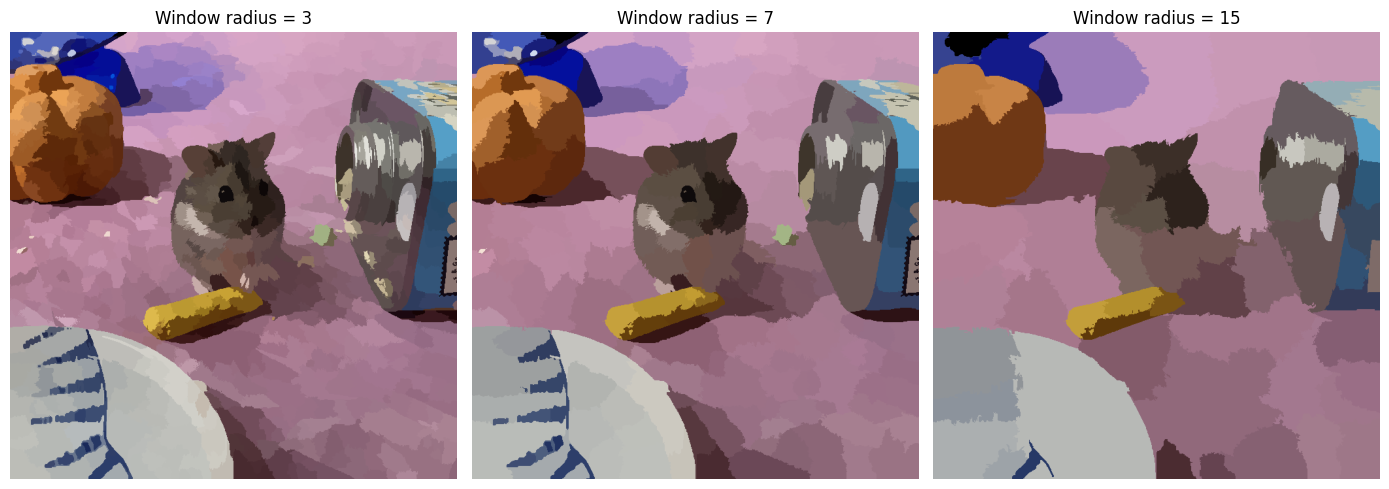

In [6]:
# reload and downsample the image
image = io.imread('IMG_8886.jpeg')
image = img_as_float(image)
image_small = transform.rescale(image, 0.25, channel_axis=2, anti_aliasing=True)

# define kernel sizes (window radii) to compare
kernel_sizes = [3, 7, 15]

# perform Mean Shift segmentation for each kernel size
segmented_images = []
for k in kernel_sizes:
    segments = quickshift(
        image_small,
        kernel_size=k,
        max_dist=15,
        ratio=0.8
    )
    segmented_image = color.label2rgb(segments, image_small, kind='avg')
    segmented_images.append(segmented_image)

# create side-by-side comparison plot
fig, axes = plt.subplots(1, len(kernel_sizes), figsize=(14, 5))
titles = [f'Window radius = {k}' for k in kernel_sizes]

for ax, seg_img, title in zip(axes, segmented_images, titles):
    ax.imshow(seg_img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

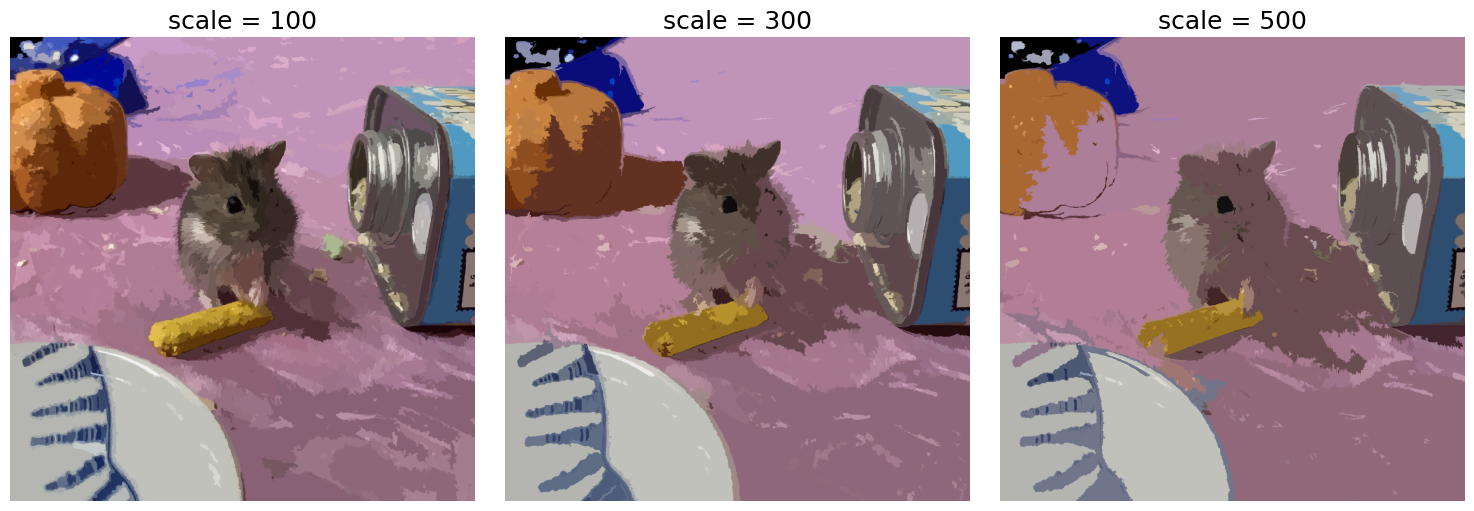

In [ ]:
# reload and downscale image
image = io.imread('IMG_8886.jpeg')
image = img_as_float(image)
image_small = rescale(image, 0.7, channel_axis=2, anti_aliasing=True)

# define k (scale) values 
k_values = [100, 300, 500]
segmented_images = []

# run Felzenszwalb segmentation
for k in k_values:
    segments = segmentation.felzenszwalb(image_small, scale=k, sigma=0.5, min_size=100)
    segmented_color = color.label2rgb(segments, image_small, kind='avg')
    segmented_images.append(segmented_color)

fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(segmented_images[i])
    ax.set_title(f'scale = {k_values[i]}', fontsize=18)
    ax.axis('off')

plt.tight_layout()
plt.show()


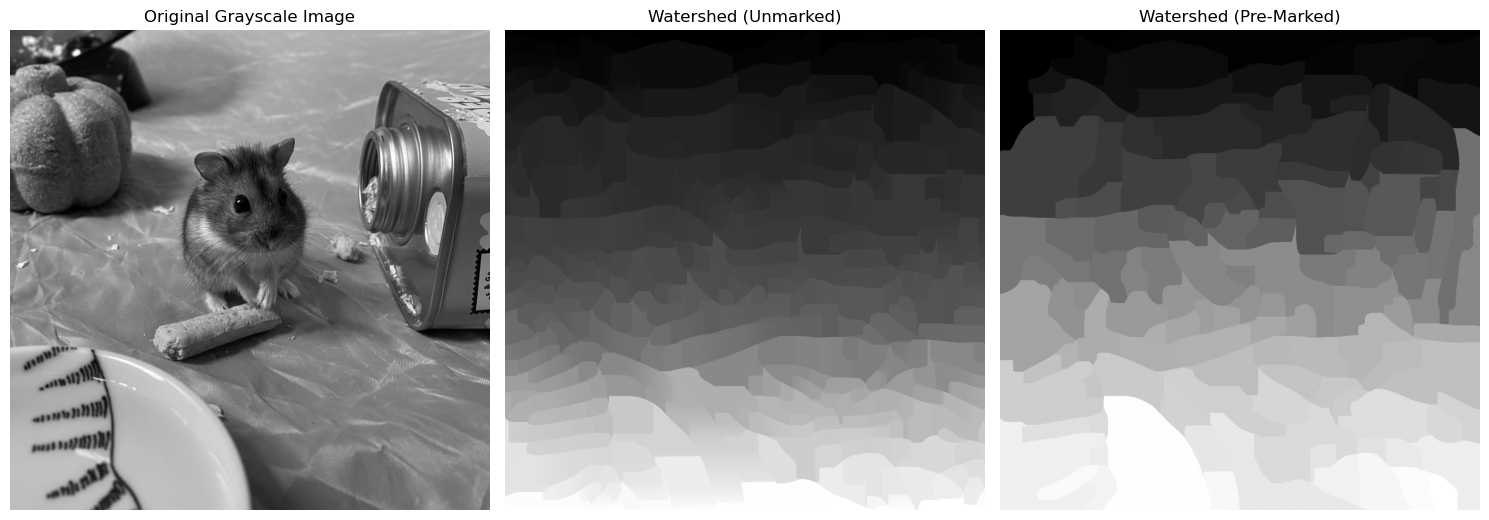

In [ ]:
# reload and downsize the image
image = io.imread('IMG_8886.jpeg')
image = img_as_float(image)
image_small = transform.rescale(image, 0.5, channel_axis=2, anti_aliasing=True)

# convert to greyscale
gray = color.rgb2gray(image_small)

# smooth to reduce noise
gray_smooth = gaussian(gray, sigma=20)

# compute the gradient map using sobel operator
elevation_map = sobel(gray_smooth)

# unmarked watershed (no predefined markers)
segments_unmarked = watershed(elevation_map)

# pre-marked watershed
coords = peak_local_max(-elevation_map, min_distance=50, labels=None)
mask = np.zeros(elevation_map.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
segments_marked = watershed(elevation_map, markers)

# plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Original Grayscale Image")
axes[0].axis('off')

axes[1].imshow(segments_unmarked, cmap='gray')
axes[1].set_title("Watershed (Unmarked)")
axes[1].axis('off')

axes[2].imshow(segments_marked, cmap='gray')
axes[2].set_title("Watershed (Pre-Marked)")
axes[2].axis('off')

plt.tight_layout()
plt.show()